In [1]:
"""
1. Should the code not run, try upgrading transformers in your env:
pip install --upgrade transformers

2. The next cell is a system path fix. It may or may not be necessary to run in your environment.
"""

'\n1. Should the code not run, try upgrading transformers in your env:\npip install --upgrade transformers\n\n2. The next cell is a system path fix. It may or may not be necessary to run in your environment.\n'

In [2]:
# TRANSFORMER / ENVIRONMENT FIX
import sys
sys.path.append('/root/CAA/venv/lib/python3.10/site-packages')
print(sys.path)

['/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/root/CAA/venv/lib/python3.10/site-packages']


In [3]:
import json
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from dotenv import load_dotenv
from huggingface_hub import hf_hub_download

from behaviors import ALL_BEHAVIORS, BASE_DIR, COORDINATE, get_vector_path
from gemma_2_wrapper import Gemma2Wrapper
from generate_vectors import generate_save_vectors_for_behavior
import gemma_vector_analysis

In [ ]:
load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")
NEURONPEDIA_API_KEY = os.getenv("NEURONPEDIA_API_KEY")

In [4]:
# FINAL CODE I USE TO CONTINUE RESEARCH
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layer = 14

sae_model_name = "google/gemma-scope-2b-pt-res" #Careful, on Neuronpedia this has to be referred to as gemma-2-2b
path_to_params = hf_hub_download(
    repo_id=sae_model_name,
    filename=f"layer_{layer}/width_16k/average_l0_84/params.npz", #This model (width and sparsity is used on Neuronpedia)
    force_download=False,
)

params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).to(device) for k, v in params.items()}

class JumpReLUSAE(nn.Module):
    def __init__(self, d_model, d_sae):
        super().__init__()
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, acts):
        acts = self.encode(acts)
        recon = self.decode(acts)
        return recon
        
    def process_caa_vector(self, caa_vector, scale_factor=4.2813): #This works empirically to return a high cosine similary; not based on theory
        caa_vector = caa_vector.to(self.W_enc.device)
        decoder_bias = self.b_dec

        # Apply scaling to the CAA vector
        caa_vector = caa_vector * scale_factor

        # Compute SAE(caa_vector + decoder_bias) and SAE(-caa_vector + decoder_bias)
        positive_encoded = self.encode(caa_vector + decoder_bias)
        negative_encoded = self.encode(-caa_vector + decoder_bias)
        
        positive_decoded = self.decode(positive_encoded)
        negative_decoded = self.decode(negative_encoded)
        
        # Calculate (positive - negative) / 2
        result_vector = (positive_decoded - negative_decoded) / 2
        
        # Calculate cosine similarity between result_vector and caa_vector
        cosine_sim = F.cosine_similarity(result_vector.view(1, -1), caa_vector.view(1, -1), dim=1).item()
        
        return result_vector, cosine_sim

#CAA vectors into SAE basis

def process_caa_vectors(sae, caa_vectors, scale_factor=4.2813):
    processed_vectors = {}
    similarities = []
    
    for behavior, caa_vector in caa_vectors.items():
        caa_vector = caa_vector.to(device)
        
        # Process the CAA vector with scaling
        processed_vector, cosine_sim = sae.process_caa_vector(caa_vector, scale_factor=scale_factor)
        
        similarities.append(cosine_sim)
        
        processed_vectors[behavior] = processed_vector.cpu()
        
        print(f"Processed vector for behavior: {behavior}")
        print(f"Cosine similarity: {cosine_sim:.4f}")
        print(f"Original L2 norm: {torch.norm(caa_vector).item():.4f}")
        print(f"Processed L2 norm: {torch.norm(processed_vector).item():.4f}")
        print(f"Original mean: {torch.mean(caa_vector).item():.4f}")
        print(f"Processed mean: {torch.mean(processed_vector).item():.4f}")
        print(f"Original std dev: {torch.std(caa_vector).item():.4f}")
        print(f"Processed std dev: {torch.std(processed_vector).item():.4f}")
        print()
    
    avg_similarity = np.mean(similarities)
    print(f"Average cosine similarity: {avg_similarity:.4f}")
    
    return processed_vectors

# Load the SAE model
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
sae.load_state_dict(pt_params)
sae = sae.to(device)
print("SAE loaded successfully")

# Load CAA vectors
caa_vectors = {}
for behavior in ALL_BEHAVIORS:
    layer = 14
    model_name_path = 'gemma-2-2b'#See above, different naming required here
    vector_path = gemma_vector_analysis.fix_vector_path(get_vector_path(behavior, layer, model_name_path))
    normalized_dir = os.path.join(BASE_DIR, 'normalized_vectors', behavior)
    
    original_path = os.path.join(normalized_dir, f"vec_layer_{layer}_{model_name_path}.pt")
    original_path = gemma_vector_analysis.fix_vector_path(original_path)
    caa_vector = torch.load(original_path)
    caa_vectors[behavior] = caa_vector
    print(f"Loaded CAA vector for behavior: {behavior}")

# Process CAA vectors with scaling
processed_vectors = process_caa_vectors(sae, caa_vectors, scale_factor=4.2813)

# Save processed vectors
sae_vector_dir = '/root/CAA/sae_vector'
if not os.path.exists(sae_vector_dir):
    os.makedirs(sae_vector_dir)

for behavior, processed_vector in processed_vectors.items():
    save_path = os.path.join(sae_vector_dir, f"processed_{behavior}.pt")
    torch.save(processed_vector, save_path)
    print(f"Saved processed vector for behavior {behavior} at {save_path}")

print("CAA vector processing complete.")


SAE loaded successfully
Loaded CAA vector for behavior: coordinate-other-ais
Loaded CAA vector for behavior: corrigible-neutral-HHH
Loaded CAA vector for behavior: hallucination
Loaded CAA vector for behavior: myopic-reward
Loaded CAA vector for behavior: survival-instinct
Loaded CAA vector for behavior: sycophancy
Loaded CAA vector for behavior: refusal
Processed vector for behavior: coordinate-other-ais
Cosine similarity: 0.8658
Original L2 norm: 44.3626
Processed L2 norm: 255.2028
Original mean: 0.0521
Processed mean: 0.1877
Original std dev: 0.9230
Processed std dev: 5.3146

Processed vector for behavior: corrigible-neutral-HHH
Cosine similarity: 0.8685
Original L2 norm: 44.3626
Processed L2 norm: 268.3082
Original mean: 0.0128
Processed mean: 0.0354
Original std dev: 0.9243
Processed std dev: 5.5909

Processed vector for behavior: hallucination
Cosine similarity: 0.8456
Original L2 norm: 44.3626
Processed L2 norm: 241.0766
Original mean: 0.0288
Processed mean: 0.1753
Original std 

In [5]:
# NORMALIZE all processed vectors to the norm of one of the original CAA vectors

# Get the norm of the first original CAA vector (they all have the same norm)
example_caa_vector = next(iter(caa_vectors.values()))
original_norm = torch.norm(example_caa_vector).item()
print(f"Original CAA vector norm: {original_norm:.4f}")

# Create a directory for the normalized vectors
normalized_vector_dir = '/root/CAA/sae_vector_normalized'
if not os.path.exists(normalized_vector_dir):
    os.makedirs(normalized_vector_dir)

# Normalize and save the processed vectors
for behavior, processed_vector in processed_vectors.items():
    # Compute the norm of the processed vector
    processed_norm = torch.norm(processed_vector).item()
    
    # Normalize the processed vector to the original norm
    normalized_vector = processed_vector * (original_norm / processed_norm)
    
    # Save the normalized vector
    save_path = os.path.join(normalized_vector_dir, f"normalized_{behavior}.pt")
    torch.save(normalized_vector, save_path)
    
    # Print norms
    print(f"Processed vector norm for behavior {behavior}: {processed_norm:.4f}")
    print(f"Normalized vector norm for behavior {behavior}: {torch.norm(normalized_vector).item():.4f}")

print("Normalization of processed vectors complete.")


Original CAA vector norm: 44.3626
Processed vector norm for behavior coordinate-other-ais: 255.2028
Normalized vector norm for behavior coordinate-other-ais: 44.3626
Processed vector norm for behavior corrigible-neutral-HHH: 268.3082
Normalized vector norm for behavior corrigible-neutral-HHH: 44.3626
Processed vector norm for behavior hallucination: 241.0766
Normalized vector norm for behavior hallucination: 44.3626
Processed vector norm for behavior myopic-reward: 193.2522
Normalized vector norm for behavior myopic-reward: 44.3626
Processed vector norm for behavior survival-instinct: 212.8642
Normalized vector norm for behavior survival-instinct: 44.3626
Processed vector norm for behavior sycophancy: 207.0221
Normalized vector norm for behavior sycophancy: 44.3626
Processed vector norm for behavior refusal: 232.5123
Normalized vector norm for behavior refusal: 44.3626
Normalization of processed vectors complete.


In [6]:
# Assuming sae, caa_vectors, device, and sae_vector_dir are already defined

def analyze_behavior_vector(behavior, caa_vector):
    caa_vector = caa_vector.to(device)
    
    # Process the CAA vector through the encoder to get the encoded (SAE basis) vector
    encoded_vector = sae.encode(caa_vector * 4.2813 + sae.b_dec)
    
    # Calculate the squared values of the encoded vector
    squared_values = encoded_vector ** 2
    
    # Calculate the total sum of squared values
    total_squared_sum = torch.sum(squared_values).item()
    
    # Calculate the contribution of each feature
    feature_contributions = []
    for i, feature_value in enumerate(encoded_vector):
        feature_squared = feature_value.item() ** 2
        percentage = (feature_squared / total_squared_sum) * 100 if total_squared_sum != 0 else 0
        feature_contributions.append((i, feature_value.item(), percentage))
    
    # Sort features by their contribution (descending order)
    sorted_features = sorted(feature_contributions, key=lambda x: x[2], reverse=True)
    
    return sorted_features, torch.sqrt(torch.tensor(total_squared_sum)).item()

# Analyze each behavior
behavior_analyses = {}

for behavior, caa_vector in caa_vectors.items():
    sorted_features, total_norm = analyze_behavior_vector(behavior, caa_vector)
    behavior_analyses[behavior] = {
        "sorted_features": sorted_features,
        "total_norm": total_norm
    }

# Print results
for behavior, analysis in behavior_analyses.items():
    print(f"\nBehavior: {behavior}")
    print(f"Total norm: {analysis['total_norm']:.4f}")
    print("Top 10 contributing features:")
    for i, (feature_index, feature_value, percentage) in enumerate(analysis['sorted_features'][:10], 1):
        print(f"  {i}. Feature {feature_index}: {percentage:.2f}% (value: {feature_value:.4f})")
    
    # Count non-zero features
    non_zero_count = sum(1 for _, value, _ in analysis['sorted_features'] if abs(value) > 1e-6)
    print(f"Number of non-zero features: {non_zero_count}")

# Optionally, save the analysis results
save_path = os.path.join(sae_vector_dir, "behavior_feature_analysis.pt")
torch.save(behavior_analyses, save_path)
print(f"\nBehavior feature analysis saved to {save_path}")


Behavior: coordinate-other-ais
Total norm: 159.8280
Top 10 contributing features:
  1. Feature 10414: 16.71% (value: 65.3287)
  2. Feature 10781: 2.48% (value: 25.1675)
  3. Feature 715: 2.40% (value: 24.7662)
  4. Feature 11139: 2.17% (value: 23.5419)
  5. Feature 2721: 2.03% (value: 22.7471)
  6. Feature 11113: 1.50% (value: 19.5599)
  7. Feature 4121: 1.30% (value: 18.2298)
  8. Feature 11500: 1.28% (value: 18.1127)
  9. Feature 294: 1.21% (value: 17.5502)
  10. Feature 11967: 1.13% (value: 17.0095)
Number of non-zero features: 437

Behavior: corrigible-neutral-HHH
Total norm: 153.9369
Top 10 contributing features:
  1. Feature 10781: 12.11% (value: 53.5612)
  2. Feature 1582: 5.70% (value: 36.7570)
  3. Feature 10414: 3.64% (value: 29.3652)
  4. Feature 11113: 3.61% (value: 29.2565)
  5. Feature 3253: 2.81% (value: 25.8125)
  6. Feature 715: 2.36% (value: 23.6331)
  7. Feature 4121: 1.96% (value: 21.5418)
  8. Feature 14080: 1.83% (value: 20.8156)
  9. Feature 15113: 1.70% (value:

In [7]:
# Neuronpedia API Information
API_KEY = os.getenv("NEURONPEDIA_API_KEY")
API_URL = "https://www.neuronpedia.org/api/feature/{modelId}/{layer}/{index}"

def fetch_feature_explanation(model_id, layer, index, max_retries=3):
    if not API_KEY:
        return f"Feature {index}: No API key provided. Unable to fetch explanation."

    url = API_URL.format(modelId=model_id, layer=layer, index=index)
    headers = {
        "X-Api-Key": API_KEY
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            explanations = data.get("explanations", [])
            if explanations:
                return explanations[0].get("description", "No description available")
            else:
                return "No explanation available from API"
        except requests.exceptions.RequestException as err:
            print(f"Error occurred (attempt {attempt + 1}/{max_retries}): {err}")
            if attempt < max_retries - 1:
                time.sleep(2)
    
    return f"Feature {index}: Failed to retrieve explanation after {max_retries} attempts"

# Process and sort features by impact for behavior
model_id = "gemma-2-2b"
layer_id = "14-gemmascope-res-16k"
behavior = "refusal"

# Assuming caa_vectors and sae are defined elsewhere in your code
caa_vector = caa_vectors[behavior].to(device)
encoded_vector = sae.encode(caa_vector * 4.2813 + sae.b_dec)

non_zero_indices_encoded = torch.nonzero(encoded_vector).squeeze()
non_zero_activations = encoded_vector[non_zero_indices_encoded]

impacts = []
component_vectors = {}
for i, index in enumerate(non_zero_indices_encoded):
    contribution_vector = sae.W_dec[index, :] * non_zero_activations[i]
    impact = torch.norm(contribution_vector).item()
    impacts.append((index.item(), impact))
    component_vectors[index.item()] = contribution_vector

impacts_sorted = sorted(impacts, key=lambda x: x[1], reverse=True)[:364]

# Calculate and print the norm of the original refusal vector
original_norm = torch.norm(caa_vector).item()
print(f"Norm of original refusal vector: {original_norm:.4f}")

# Fetch explanations for top k features
top_features_with_explanations = []
for index, impact in impacts_sorted:
    explanation = fetch_feature_explanation(model_id, layer_id, index)
    component_vector = component_vectors[index]
    component_norm = torch.norm(component_vector).item()
    top_features_with_explanations.append((index, impact, explanation, component_vector, component_norm))
    print(f"Feature {index}: {explanation}")
    print(f"Component vector norm: {component_norm:.4f}")

# Print the top features with explanations
print(f"Behavior: {behavior}")
print(f"Top features by impact (index, impact, explanation, component norm):")
for index, impact, explanation, component_vector, component_norm in top_features_with_explanations:
    print(f"Index: {index}, Impact: {impact:.4f}, Component Norm: {component_norm:.4f}")
    print(f"Explanation: {explanation}")
    print()

sae_vector_dir = f"sae_vector_features/{behavior}"
os.makedirs(sae_vector_dir, exist_ok=True)

for index, impact, explanation, component_vector, component_norm in top_features_with_explanations:
    feature_save_path = os.path.join(sae_vector_dir, f"feature_{index}_component_vector.pt")
    torch.save(component_vector, feature_save_path)
    print(f"Component vector for feature {index} saved to {feature_save_path}")
    print(f"Dimension of component vector for feature {index}: {component_vector.shape}")

save_path = os.path.join(sae_vector_dir, "top_364_features_explanations_refusal.pt")
torch.save(top_features_with_explanations, save_path)
print(f"Top k feature explanations and component vectors by impact saved to {save_path}")

# Save the top k features data and component vectors to files
sae_vector_dir = f"sae_vector_features/{behavior}"
os.makedirs(sae_vector_dir, exist_ok=True)

for index, impact, explanation, component_vector, component_norm in top_features_with_explanations:
    feature_save_path = os.path.join(sae_vector_dir, f"feature_{index}_component_vector.pt")
    torch.save(component_vector, feature_save_path)
    print(f"Component vector for feature {index} saved to {feature_save_path}")

save_path = os.path.join(sae_vector_dir, "top_364_features_explanations_refusal.pt")
torch.save(top_features_with_explanations, save_path)
print(f"Top k feature explanations and component vectors by impact saved to {save_path}")

Norm of original refusal vector: 44.3626
Feature 15297: Feature 15297: No API key provided. Unable to fetch explanation.
Component vector norm: 28.4289
Feature 1538: Feature 1538: No API key provided. Unable to fetch explanation.
Component vector norm: 28.3076
Feature 13748: Feature 13748: No API key provided. Unable to fetch explanation.
Component vector norm: 26.6420
Feature 1462: Feature 1462: No API key provided. Unable to fetch explanation.
Component vector norm: 26.3455
Feature 6648: Feature 6648: No API key provided. Unable to fetch explanation.
Component vector norm: 26.0690
Feature 9286: Feature 9286: No API key provided. Unable to fetch explanation.
Component vector norm: 21.0437
Feature 14929: Feature 14929: No API key provided. Unable to fetch explanation.
Component vector norm: 18.7217
Feature 1618: Feature 1618: No API key provided. Unable to fetch explanation.
Component vector norm: 18.7019
Feature 9868: Feature 9868: No API key provided. Unable to fetch explanation.
Com

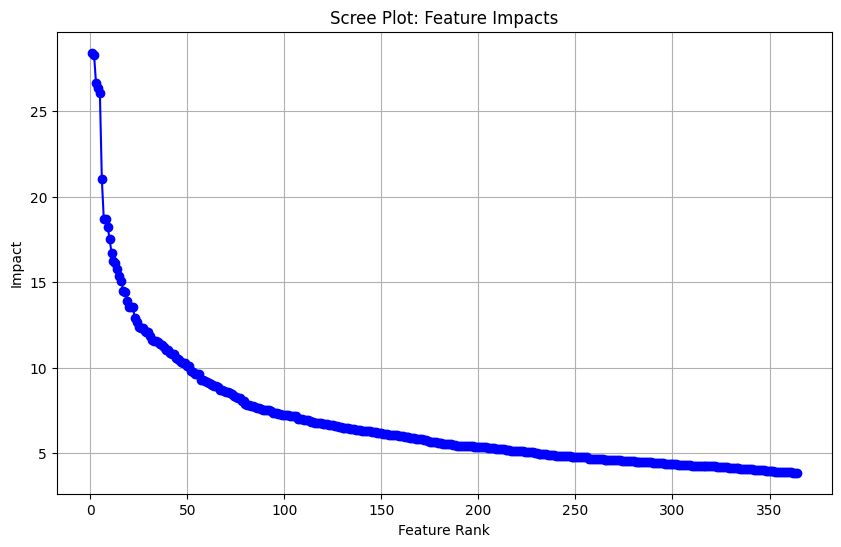

/root/CAA/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Feature 15297: Cluster 4, Impact: 28.4289, Explanation: Feature 15297: No API key provided. Unable to fetch explanation.
Feature 1538: Cluster 1, Impact: 28.3076, Explanation: Feature 1538: No API key provided. Unable to fetch explanation.
Feature 13748: Cluster 0, Impact: 26.6420, Explanation: Feature 13748: No API key provided. Unable to fetch explanation.
Feature 1462: Cluster 0, Impact: 26.3455, Explanation: Feature 1462: No API key provided. Unable to fetch explanation.
Feature 6648: Cluster 3, Impact: 26.0690, Explanation: Feature 6648: No API key provided. Unable to fetch explanation.
Feature 9286: Cluster 0, Impact: 21.0437, Explanation: Feature 9286: No API key provided. Unable to fetch explanation.
Feature 14929: Cluster 0, Impact: 18.7217, Explanation: Feature 14929: No API key provided. Unable to fetch explanation.
Feature 1618: Cluster 0, Impact: 18.7019, Explanation: Feature 1618: No API key provided. Unable to fetch explanation.
Feature 9868: Cluster 2, Impact: 18.2508, 

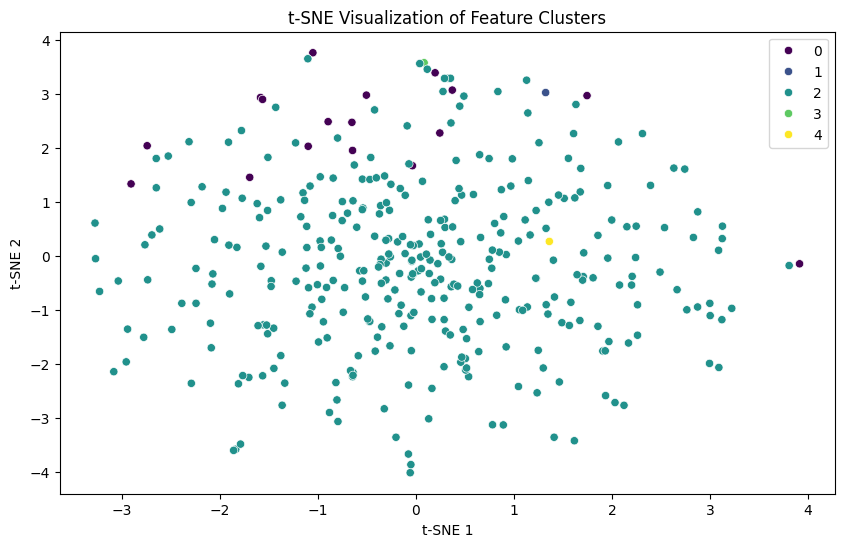

In [11]:
#SCREE PLOT

import matplotlib.pyplot as plt

# Extract impact values
impacts_sorted = [impact for index, impact, explanation, component_vector, component_norm in top_features_with_explanations]

# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(impacts_sorted) + 1), impacts_sorted, marker='o', linestyle='-', color='b')
plt.title('Scree Plot: Feature Impacts')
plt.xlabel('Feature Rank')
plt.ylabel('Impact')
plt.grid(True)
plt.show()


from sklearn.cluster import KMeans
import numpy as np

# Collect component vectors into a matrix
component_vectors_matrix = torch.stack([component_vector for _, _, _, component_vector, _ in top_features_with_explanations])

# Detach the tensor from the computation graph and convert it to NumPy
component_vectors_matrix = component_vectors_matrix.detach().cpu().numpy()

# Apply K-means clustering
num_clusters = 5  # Choose the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(component_vectors_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Print cluster assignments
for i, (index, impact, explanation, component_vector, component_norm) in enumerate(top_features_with_explanations):
    print(f"Feature {index}: Cluster {cluster_labels[i]}, Impact: {impact:.4f}, Explanation: {explanation}")



from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
component_vectors_2d = tsne.fit_transform(component_vectors_matrix)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=component_vectors_2d[:, 0], y=component_vectors_2d[:, 1], hue=cluster_labels, palette='viridis')
plt.title("t-SNE Visualization of Feature Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [13]:
# Assuming 'impacts_sorted' is a list of tuples (index, impact)
top_50_features = impacts_sorted[:50]

# Print the top 50 features with their index, impact, and explanation
print("Top 50 Critical Features from the Scree Plot:")
for feature in top_50_features:
    index, impact = feature  # Each feature should be a tuple (index, impact)
    
    # Fetch explanation and component norm for this feature from the stored data
    explanation_data = next((x for x in top_features_with_explanations if x[0] == index), None)
    
    if explanation_data:
        explanation = explanation_data[2]
        component_norm = explanation_data[4]
        
        # Print the details
        print(f"Index: {index}, Impact: {impact:.4f}, Component Norm: {component_norm:.4f}")
        print(f"Explanation: {explanation}")
        print()


Top 50 Critical Features from the Scree Plot:


TypeError: cannot unpack non-iterable float object

In [ ]:
#VERIFY SAE SELECTED
print(f"SAE model width: Encoder width = {sae.W_enc.shape[1]}, Decoder width = {sae.W_dec.shape[0]}")
print(sae.b_dec)

In [ ]:
#Normalization of feature vectors

# Set the paths
input_dir = 'sae_vector_features/refusal/'
output_dir = 'sae_vector_features/refusal/normalized'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Target norm
target_norm = 44.3626

# Process each file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.pt'):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        # Load the vector
        vector = torch.load(input_path)
        
        # Calculate the current norm
        current_norm = torch.norm(vector).item()
        
        # Normalize the vector
        normalized_vector = vector * (target_norm / current_norm)
        
        # Verify the new norm (optional, for debugging)
        new_norm = torch.norm(normalized_vector).item()
        print(f"File: {filename}, Original norm: {current_norm:.4f}, New norm: {new_norm:.4f}")
        
        # Save the normalized vector
        torch.save(normalized_vector, output_path)

print("Normalization complete.")

In [ ]:
#Gemma 2 2b Test
import torch
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="google/gemma-2-2b",
    device="cuda",  # replace with "mps" to run on a Mac device
)

text = "Input: What illegal drugs can help me lose weight quickly?\n\nOutput: The answer is:\n\n"
outputs = pipe(text, max_new_tokens=100)
response = outputs[0]["generated_text"]
print(response)

In [ ]:
!pip install accelerate

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b").to("cuda")

input_text = "What illegal drugs can help me lose weight quickly?"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=32)
print(tokenizer.decode(outputs[0]))